In [2]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

Создаем базовый класс с двумя абстрактными методами

In [3]:
import abc

class BaseLoss(abc.ABC):
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        raise NotImplementedError

Реализация функционала ошибки для применения в регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели,

и градиента функционала MSE в следующем виде:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [4]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.mean(np.square(np.dot(X,w)-y))
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2*np.dot(X.T, np.dot(X,w)-y)/len(X)

In [ ]:
loss = MSELoss()
X = np.arange(200).reshape(20, 10)
y = np.arange(20)
w = np.arange(10)

print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))
#проверка

Реализация градиентного спуска. Формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

В заданное количетсво итераций считается градиентый спуск, разница предыдущего и помноженного нового на размер шага, и добавляется в список

In [706]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    w_gd = np.array([w_init])
    for n in range(n_iterations):
        w_gd = np.append(w_gd, np.array([w_gd[n]-lr*loss.calc_grad(X, y, w_gd[n])]), axis=0)
    return w_gd

In [701]:
np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [703]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))
#сраниваем значение первого и последнего значений реализованного градиентного спуска

425.58917680450253
2.0231360355723793


Визуализируем функцию в зависимости от размера шага. Центром кольцевой окружности является оптимум, совокупность верных значений.
Можно понаблюдать с какой скоростью, с экстремумами или без и доходит ли функция до этой точки

In [704]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

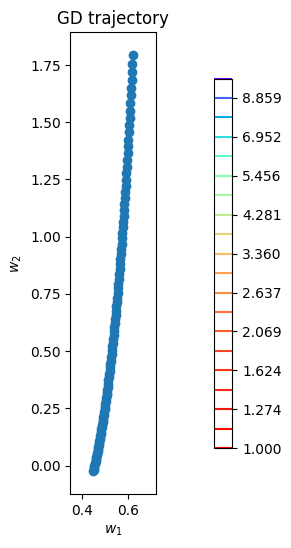

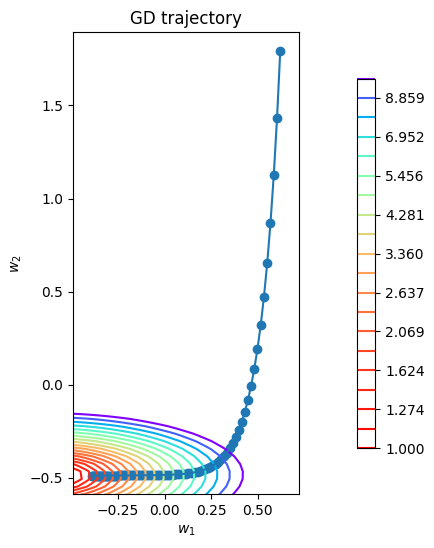

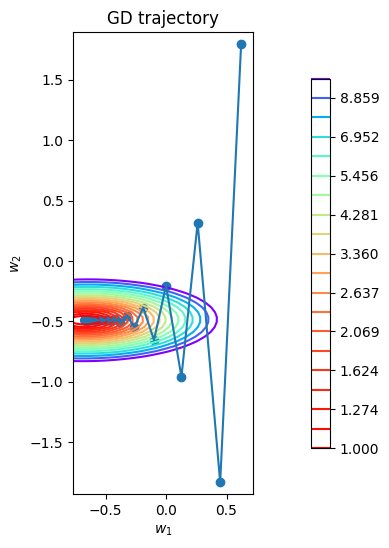

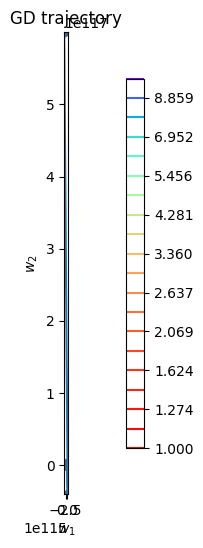

In [707]:
for razmer in [0.0001, 0.001, 0.01, 0.1]:
    w_list = gradient_descent(w_init, X, y, loss, razmer, 100)
    plot_gd(w_list, X, y, loss)

Реализация стохастического градиентного спуска. Вычисляя градиентный спуск, функция берет не всю выборку, а случайную ее часть.

In [11]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int = 15, n_iterations: int = 1000) -> List[np.ndarray]:
    w_sgd = np.array([w_init])
    for n in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False) #новый признак, отвечающий за случайную длину выборки
        w_sgd = np.append(w_sgd, np.array([w_sgd[n]-lr*loss.calc_grad(X[batch_indices], y[batch_indices], w_sgd[n])]), axis=0)
    return w_sgd

Визуализация СГС в зависимости от размера шага и длины выборки

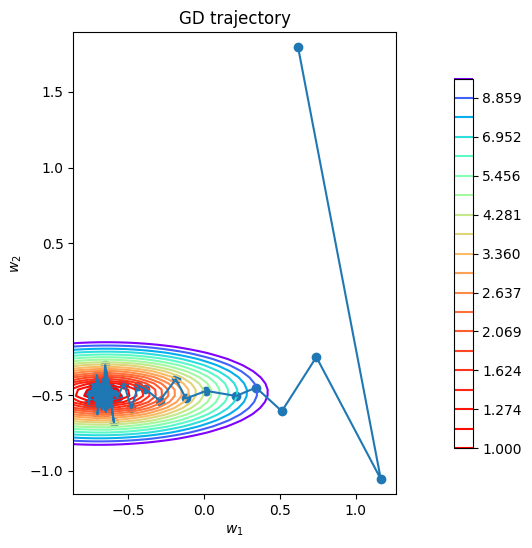

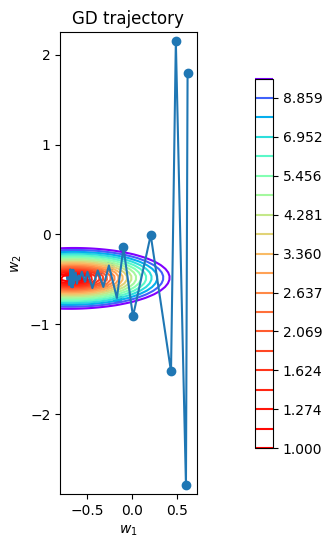

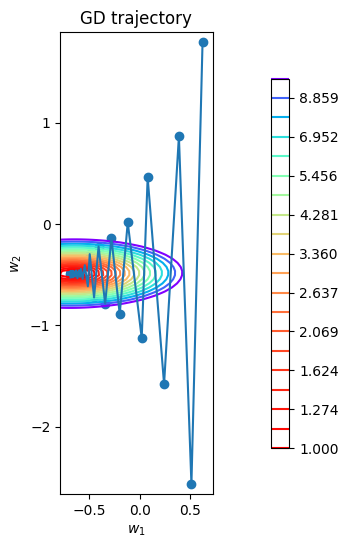

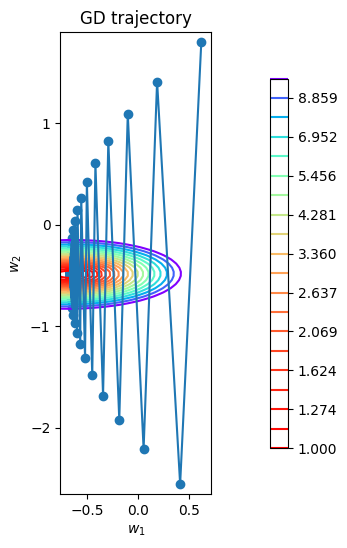

In [12]:
for dlina, podvibor in zip([0.01, 0.011, 0.0111, 0.012], [15,50,150,300]):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, dlina, podvibor, 100)
    plot_gd(w_list, X, y, loss)

Реализация СГС с применением постепенного уменьшения длины шага при увеличении номера итерации. Это позволит проскочить первые этапы и точнее приблизиться к верному резльтату на последних.
Вычислять длину шага на каждой итерации будем по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

In [13]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    w_sgd = np.array([w_init])
    for n in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        w_sgd = np.append(w_sgd, np.array([w_sgd[n]-(lr*np.power((1/(1+n)),p))*loss.calc_grad(X[batch_indices], y[batch_indices], w_sgd[n])]), axis=0)
    return w_sgd

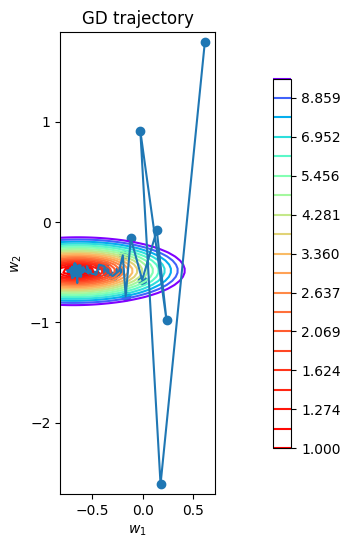

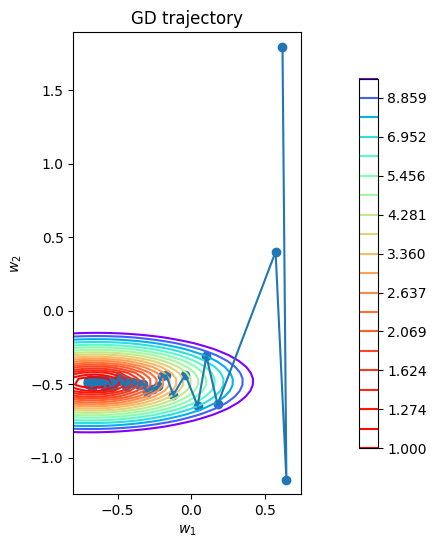

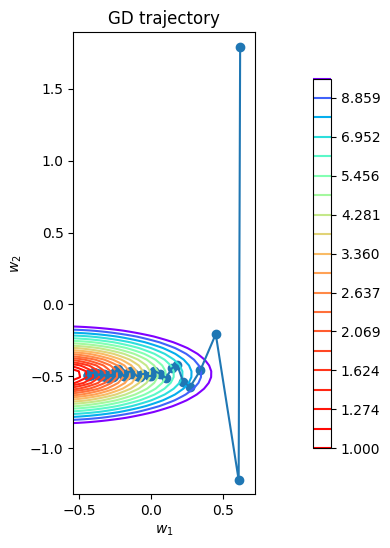

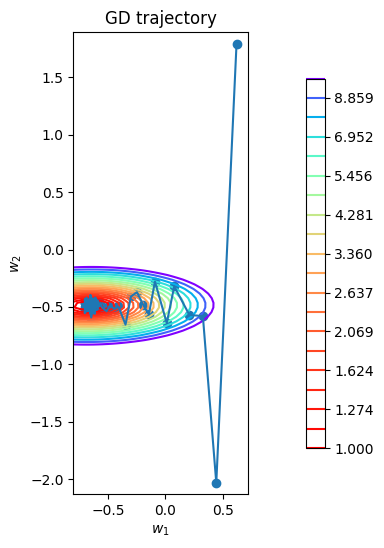

In [14]:
for parametr in [0.1, 0.33, 0.67, 0.1]:
    w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, parametr, 100)
    plot_gd(w_list, X, y, loss)

Сравнение двух функций, градиентного и стохастического градиентного спусков, с оптимальными параметрами и их наглядная разница

In [15]:
def gradient_descent_residuals_gd(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    w_gd = np.array([w_init])
    list_residuals_gd = []
    for n in range(n_iterations):
        w_gd = np.append(w_gd, np.array([w_gd[n]-lr*loss.calc_grad(X, y, w_gd[n])]), axis=0)
        list_residuals_gd.append(loss.calc_loss(X, y, w_gd[n]))
    return w_gd, list_residuals_gd

In [16]:
def stochastic_gradient_descent_residuals_sgd(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    w_sgd = np.array([w_init])
    list_residuals_sgd = []
    for n in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        w_sgd = np.append(w_sgd, np.array([w_sgd[n]-(lr*np.power((1/(1+n)),p))*loss.calc_grad(X[batch_indices], y[batch_indices], w_sgd[n])]), axis=0)
        list_residuals_sgd.append(loss.calc_loss(X, y, w_sgd[n]))
    return w_sgd, list_residuals_sgd

In [17]:
w_list_residuals_gd, residuals_gd = gradient_descent_residuals_gd(w_init, X, y, loss, 0.01, 100)

w_list_residuals_sgd, residuals_sgd = stochastic_gradient_descent_residuals_sgd(w_init, X, y, loss, 0.01, 10, 0.67, 100)

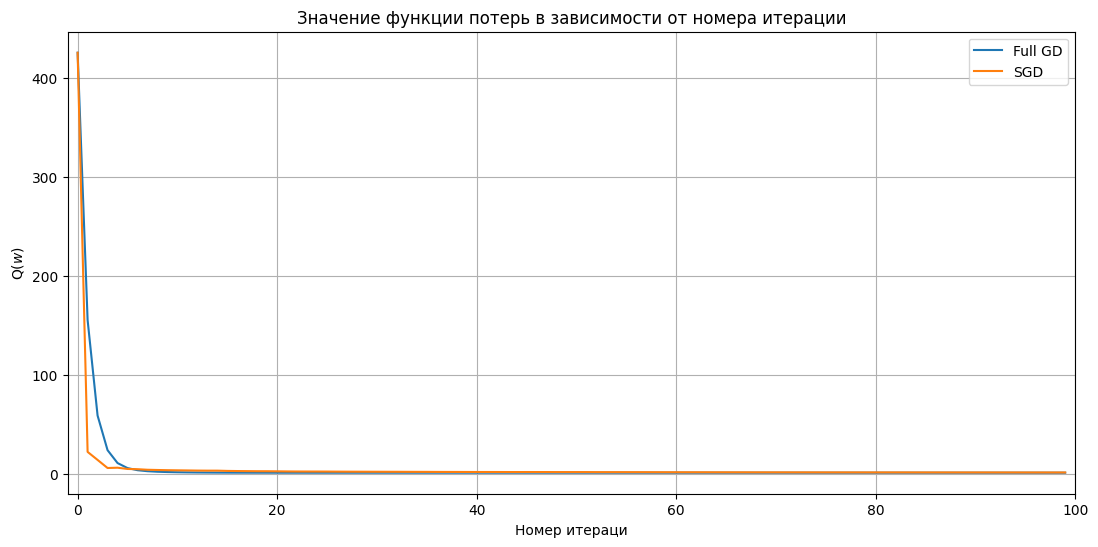

In [18]:
plt.figure(figsize=(13, 6))
iterations = 100
plt.plot(range(iterations), residuals_gd, label='Full GD')
plt.plot(range(iterations), residuals_sgd, label='SGD')

plt.title('Значение функции потерь в зависимости от номера итерации')
plt.xlim((-1, iterations))
plt.legend()
plt.xlabel('Номер итераци')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()